# Поиск изображения по текстовому описанию
Необходимо разработать демонстрационную версию поиска изображений по запросу.

Для демонстрационной версии нужно обучить модель, которая получит векторное представление изображения, векторное представление текста, а на выходе выдаст число от 0 до 1 — покажет, насколько текст и картинка подходят друг другу.

**Описание данных**

В файле `train_dataset.csv` находится информация, необходимая для обучения: имя файла изображения, идентификатор описания и текст описания. Для одной картинки может быть доступно до 5 описаний. Идентификатор описания имеет формат `<имя файла изображения>#<порядковый номер описания>`.

В папке `train_images` содержатся изображения для тренировки модели.

В файле `CrowdAnnotations.tsv` — данные по соответствию изображения и описания, полученные с помощью краудсорсинга. Номера колонок и соответствующий тип данных:

1. Имя файла изображения.
2. Идентификатор описания.
3. Доля людей, подтвердивших, что описание соответствует изображению.
4. Количество человек, подтвердивших, что описание соответствует изображению.
5. Количество человек, подтвердивших, что описание не соответствует изображению.

В файле `ExpertAnnotations.tsv` содержатся данные по соответствию изображения и описания, полученные в результате опроса экспертов. Номера колонок и соответствующий тип данных:

1. Имя файла изображения.
2. Идентификатор описания.

3, 4, 5 — оценки трёх экспертов.

Эксперты ставят оценки по шкале от 1 до 4, где 1 — изображение и запрос совершенно не соответствуют друг другу, 2 — запрос содержит элементы описания изображения, но в целом запрос тексту не соответствует, 3 — запрос и текст соответствуют с точностью до некоторых деталей, 4 — запрос и текст соответствуют полностью.

В файле `test_queries.csv` находится информация, необходимая для тестирования: идентификатор запроса, текст запроса и релевантное изображение. Для одной картинки может быть доступно до 5 описаний. Идентификатор описания имеет формат `<имя файла изображения>#<порядковый номер описания>`.

В папке `test_images` содержатся изображения для тестирования модели.

## Анализ данных

In [1]:
!pip install termcolor -q

In [2]:
!pip install translate -q

In [3]:
!pip install spacy -q

In [4]:
!spacy download en_core_web_sm -q

[+] Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [5]:
import pandas as pd
from pandas.plotting import table
import numpy as np
from termcolor import colored, cprint
import matplotlib.pyplot as plt
import seaborn as sns
import io
import os
from PIL import Image
from translate import Translator
import spacy
import re
from math import ceil
import torch
import torchvision.models as models
import torch.nn as nn
from torchvision import transforms
import transformers
from tqdm import notebook
from sklearn.model_selection import GroupShuffleSplit
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import mean_absolute_error

In [6]:
# для запуска из Colab чтобы был доступ к данным на Google-диск
try:
    from google.colab import drive
    drive.mount('/content/drive')
except:
    pass

In [7]:
constant = 12345                                   # для random_state, seed
state    = np.random.RandomState(constant)

In [8]:
np.random.seed(constant)
torch.manual_seed(constant)

Дерево структуры исходных материалов. Сформировано в GitBash.

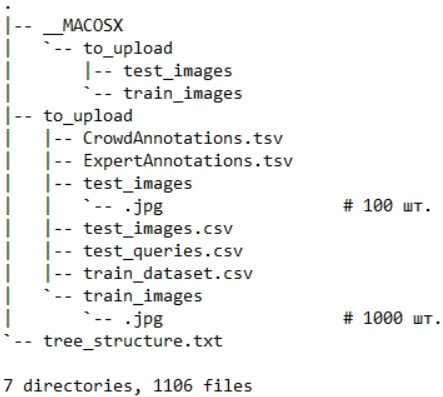

In [9]:
path_1 = '../../23 сборный проект 4/dsplus_integrated_project_4/to_upload/' # путь к исходным данным относительно тетради
path_2 = ''                                                   # альтернативный путь, например, для прописывания ревьюером
# путь для запуска тетради из Colab для доступа к данным на Google-диск
path_3 = '/content/drive/MyDrive/Data Science learning/project_image_search_by_text/dsplus_integrated_project_4/to_upload/'

In [10]:
def read_data(path):
    '''считывание исходных датасетов; аргументы подобраны согласно особенностям датасетов'''
    global train_dataset, test_images, test_queries, CrowdAnnotations, ExpertAnnotations, train_images_dir, test_images_dir
    train_dataset     = pd.read_csv(path + 'train_dataset.csv')
    test_images       = pd.read_csv(path + 'test_images.csv')
    test_queries      = pd.read_csv(path + 'test_queries.csv',      sep='|',  index_col = 0)
    CrowdAnnotations  = pd.read_csv(path + 'CrowdAnnotations.tsv',  sep='\t', header=None,
                                    names=['image', 'query_id', 'confirmation_share',
                                           'confirmation_votes','disconfirmation_votes'])
    ExpertAnnotations = pd.read_csv(path + 'ExpertAnnotations.tsv', sep='\t', header=None,
                                    names=['image', 'query_id', 'assessment_1', 'assessment_2', 'assessment_3'])
    # перечень нескрытых файлов
    train_images_dir = pd.DataFrame([f for f in os.listdir(path + 'train_images') if not f.startswith('.')], columns=['image'])
    test_images_dir  = pd.DataFrame([f for f in os.listdir(path + 'test_images')  if not f.startswith('.')], columns=['image'])

    # добавляем в перечень нескрытых файлов столбцы с характеристиками каждого файла
    def file_characteristics(directory, file):
        im = Image.open(path + directory + '/' + file)
        return im.size, im.mode, im.format

    train_images_dir[['size', 'mode', 'format']] = pd.DataFrame(train_images_dir['image'].\
                                                      apply(lambda x: file_characteristics('train_images', x)).tolist())
    test_images_dir[['size', 'mode', 'format']]  = pd.DataFrame(test_images_dir['image'].\
                                                      apply(lambda x: file_characteristics('test_images',  x)).tolist())

# пробуем разные пути; сработавший путь принимаем за основной для дальнейшего использования
try:
    read_data(path_1)
    path = path_1
except:
    try:
        read_data(path_2)
        path = path_2
    except:
        read_data(path_3)
        path = path_3

In [11]:
datasets = 'train_dataset', 'CrowdAnnotations', 'ExpertAnnotations', 'test_images', 'test_queries'

In [12]:
def count_gaps(df):
    '''по имени df (str) возвращает число ячеек, в которых есть пробелы; поиск только в колонках 'image', 'query_id' '''
    counter = 0
    for col in globals()[df]:
        if col in ('image', 'query_id'):
            counter += (globals()[df][col].str.find(' ')+1).astype(bool).sum()
    return counter

print ('                     кол-во полных дубликатов, шт     кол-во пропусков, шт     кол-во ячеек с пробелами, шт')
for df in datasets:
    print(f"{df:20}\
            {globals()[df].duplicated().sum():3}\
            {globals()[df].isna().sum().sum():17}\
            {count_gaps(df):20}")

                     кол-во полных дубликатов, шт     кол-во пропусков, шт     кол-во ячеек с пробелами, шт
train_dataset                     0                            0                               0
CrowdAnnotations                  0                            0                               0
ExpertAnnotations                 0                            0                               0
test_images                       0                            0                               0
test_queries                      0                            0                               0


In [13]:
# первые и последние 3 строки в каждом датасете
for df in datasets:
    cprint (df+"  ⤵⤵⤵", "white", attrs=["reverse"])
    display (pd.concat([globals()[df].head(3),
                        globals()[df].tail(3)])); print()

train_dataset  ⤵⤵⤵


image                     query_id  \
0     1056338697_4f7d7ce270.jpg  2549968784_39bfbe44f9.jpg#2   
1     1262583859_653f1469a9.jpg  2549968784_39bfbe44f9.jpg#2   
2     2447284966_d6bbdb4b6e.jpg  2549968784_39bfbe44f9.jpg#2   
5819   909808296_23c427022d.jpg  2112921744_92bf706805.jpg#2   
5820   929679367_ff8c7df2ee.jpg  3651971126_309e6a5e22.jpg#2   
5821   968081289_cdba83ce2e.jpg  2292406847_f366350600.jpg#2   

                                             query_text  
0     A young child is wearing blue goggles and sitt...  
1     A young child is wearing blue goggles and sitt...  
2     A young child is wearing blue goggles and sitt...  
5819       A dog stands on the side of a grassy cliff .  
5820                       A blurry photo of two dogs .  
5821                        A man rows his boat below .


CrowdAnnotations  ⤵⤵⤵


image                     query_id  \
0      1056338697_4f7d7ce270.jpg  1056338697_4f7d7ce270.jpg#2   
1      1056338697_4f7d7ce270.jpg   114051287_dd85625a04.jpg#2   
2      1056338697_4f7d7ce270.jpg  1427391496_ea512cbe7f.jpg#2   
47827   997722733_0cb5439472.jpg   872622575_ba1d3632cc.jpg#2   
47828   997722733_0cb5439472.jpg   888425986_e4b6c12324.jpg#2   
47829   997722733_0cb5439472.jpg   997722733_0cb5439472.jpg#2   

       confirmation_share  confirmation_votes  disconfirmation_votes  
0                1.000000                   3                      0  
1                0.000000                   0                      3  
2                0.000000                   0                      3  
47827            1.000000                   3                      0  
47828            0.000000                   0                      3  
47829            0.666667                   2                      1


ExpertAnnotations  ⤵⤵⤵


image                     query_id  assessment_1  \
0     1056338697_4f7d7ce270.jpg  2549968784_39bfbe44f9.jpg#2             1   
1     1056338697_4f7d7ce270.jpg  2718495608_d8533e3ac5.jpg#2             1   
2     1056338697_4f7d7ce270.jpg  3181701312_70a379ab6e.jpg#2             1   
5819   997722733_0cb5439472.jpg  3150742439_b8a352e1e0.jpg#2             1   
5820   997722733_0cb5439472.jpg  3375070563_3c290a7991.jpg#2             1   
5821   997722733_0cb5439472.jpg   486917990_72bd4069af.jpg#2             3   

      assessment_2  assessment_3  
0                1             1  
1                1             2  
2                1             2  
5819             1             2  
5820             1             1  
5821             3             3


test_images  ⤵⤵⤵


image
0   3356748019_2251399314.jpg
1   2887171449_f54a2b9f39.jpg
2   3089107423_81a24eaf18.jpg
97  3091962081_194f2f3bd4.jpg
98  2670637584_d96efb8afa.jpg
99  2346402952_e47d0065b6.jpg


test_queries  ⤵⤵⤵


query_id  \
0    1177994172_10d143cb8d.jpg#0   
1    1177994172_10d143cb8d.jpg#1   
2    1177994172_10d143cb8d.jpg#2   
497   989851184_9ef368e520.jpg#2   
498   989851184_9ef368e520.jpg#3   
499   989851184_9ef368e520.jpg#4   

                                            query_text  \
0    Two blonde boys , one in a camouflage shirt an...   
1    Two boys are squirting water guns at each other .   
2              Two boys spraying each other with water   
497  A black dog holding a weight in its mouth stan...   
498  A black dog holds a small white dumbbell in it...   
499  The black dog has a toy in its mouth and a per...   

                         image  
0    1177994172_10d143cb8d.jpg  
1    1177994172_10d143cb8d.jpg  
2    1177994172_10d143cb8d.jpg  
497   989851184_9ef368e520.jpg  
498   989851184_9ef368e520.jpg  
499   989851184_9ef368e520.jpg

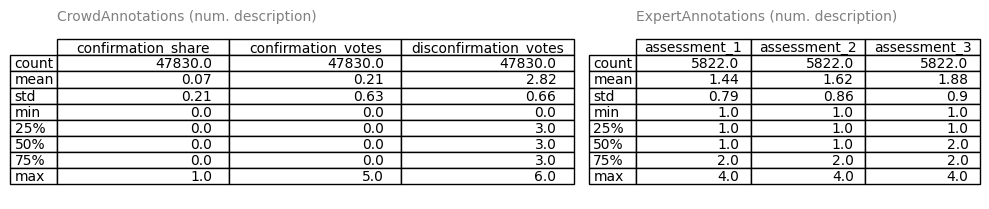

In [14]:
f, ax = plt.subplots(1, 2, figsize=(10,2.2), gridspec_kw={"width_ratios": (6, 4)})
for n, df in enumerate(('CrowdAnnotations', 'ExpertAnnotations')):
    ax[n].text(0, 1, df+' (num. description)'+'\n',c='grey')
    the_table = table(data=globals()[df].describe().round(2), ax=ax[n], loc='upper center')
    the_table.auto_set_font_size(False); ax[n].set_axis_off()
plt.tight_layout()

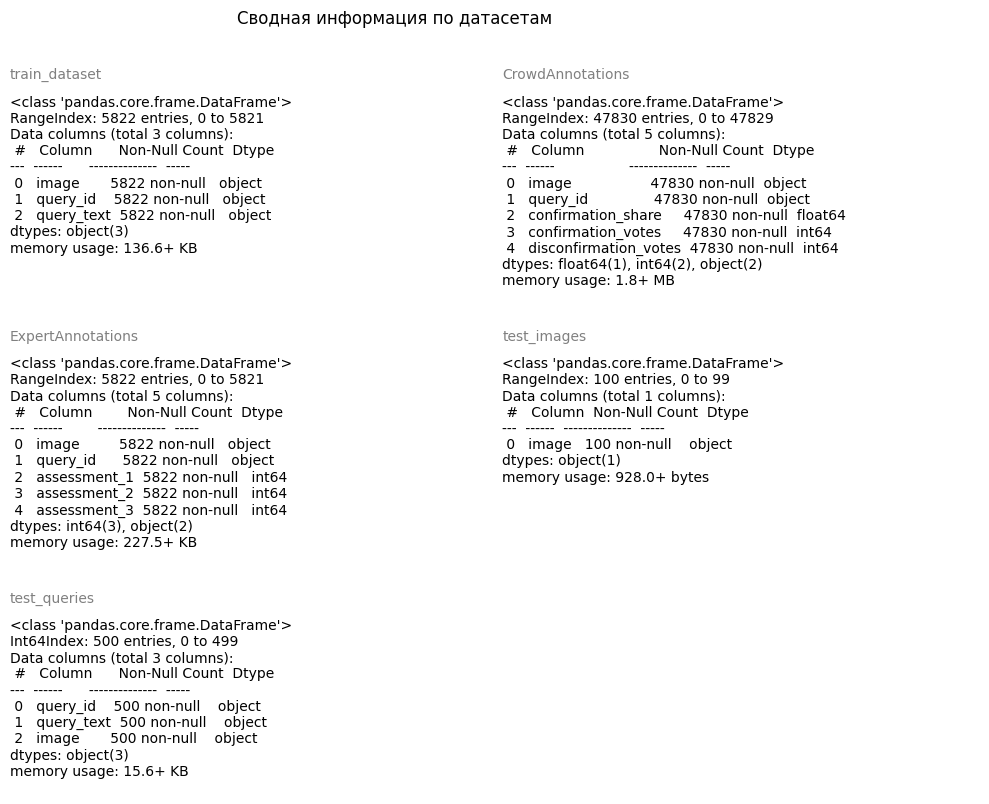

In [15]:
fig = plt.figure(figsize=(10,8))
for n, df in enumerate(datasets):

    buf = io.StringIO()                  # вывод df.info() переводим в string для применения в subplot
    globals()[df].info(buf=buf)
    string_info = buf.getvalue()

    fig.add_subplot(3, 2, n+1)
    plt.text(0, 0, df+'\n',c='grey')
    plt.text(0, 0, string_info, va='top')
    plt.axis('off')
fig.suptitle('Сводная информация по датасетам', x=0.4, y=1, fontsize=12)
plt.tight_layout()

In [16]:
# проверка корректно ли в CrowdAnnotations рассчитан confirmation_share; число строк с неправильным рассчётом с учётом погр.
CrowdAnnotations[(CrowdAnnotations['confirmation_votes']/
                 (CrowdAnnotations['confirmation_votes']+CrowdAnnotations['disconfirmation_votes'])-
                  CrowdAnnotations['confirmation_share'])
                 > 1e-10].shape[0]

0

В `CrowdAnnotations` признак `confirmation_share` может быть не корректным, если сформирован в результате опроса мизерного числа респондентов - 0, 1, 2. Чем меньше ответов, тем выше вероятность неверного `confirmation_share`.\
Проверим есть ли такие случаи.

In [17]:
CrowdAnnotations.head(2)

image                     query_id  confirmation_share  \
0  1056338697_4f7d7ce270.jpg  1056338697_4f7d7ce270.jpg#2                 1.0   
1  1056338697_4f7d7ce270.jpg   114051287_dd85625a04.jpg#2                 0.0   

   confirmation_votes  disconfirmation_votes  
0                   3                      0  
1                   0                      3

In [18]:
(CrowdAnnotations['confirmation_votes']+CrowdAnnotations['disconfirmation_votes']).value_counts()

3    46780
4      780
5      220
6       50
dtype: int64

Нет, минимальное число респондентов - 3. Немного, но не критично, как 2 и менее.

In [19]:
# удаляем лишние признаки в CrowdAnnotations; есть обобщающий признак confirmation_share
CrowdAnnotations.drop(['confirmation_votes', 'disconfirmation_votes'], axis=1, inplace=True)

In [20]:
# формируем в ExpertAnnotations 1 обобщающий нормализованный признак оценки вместо трёх;
# будет в том же диапазоне [0,1], как и confirmation_share в CrowdAnnotations
ExpertAnnotations['assessment'] = (ExpertAnnotations[['assessment_1', 'assessment_2', 'assessment_3']].mean(axis=1) - 1)/(4-1)
ExpertAnnotations.drop(['assessment_1', 'assessment_2', 'assessment_3'], axis=1, inplace=True)
ExpertAnnotations.head(2)

image                     query_id  assessment
0  1056338697_4f7d7ce270.jpg  2549968784_39bfbe44f9.jpg#2    0.000000
1  1056338697_4f7d7ce270.jpg  2718495608_d8533e3ac5.jpg#2    0.111111

Проверим все ли файлы из наличия используются в табличных датасетах; и для всех ли упомянутых в таблицах имён есть файлы:

In [21]:
# все ли картинки перечисленные в обучающих датасетах есть в наличии
for df in 'train_dataset', 'CrowdAnnotations', 'ExpertAnnotations':
    print (f"{df:20} {globals()[df]['image'].isin(train_images_dir['image']).unique()}")

train_dataset        [ True]
CrowdAnnotations     [ True]
ExpertAnnotations    [ True]


In [22]:
# все ли картинки из наличия для обучения перечислены в обучающих датасетах
for df in 'train_dataset', 'CrowdAnnotations', 'ExpertAnnotations':
    print(f"{df:20} {train_images_dir['image'].isin(globals()[df]['image']).unique()}")

train_dataset        [ True]
CrowdAnnotations     [ True]
ExpertAnnotations    [ True]


In [23]:
# все ли картинки перечисленные в тестовых датасетах есть в наличии
for df in 'test_images', 'test_queries':
    print (f"{df:20} {globals()[df]['image'].isin(test_images_dir['image']).unique()}")

test_images          [ True]
test_queries         [ True]


In [24]:
# все ли картинки из наличия для теста перечислены в тестовых датасетах
for df in 'test_images', 'test_queries':
    print(f"{df:20} {test_images_dir['image'].isin(globals()[df]['image']).unique()}")

test_images          [ True]
test_queries         [ True]


In [25]:
# топ самых популярных размеров в датасетах, width * height, pks
width_height = pd.concat([train_images_dir['size'].value_counts().head(5),
                          test_images_dir['size'].value_counts().head(5)], axis=1)
width_height.columns = ['train, pc', 'test, pc']
width_height

train, pc  test, pc
500 333      184.0      16.0
    375      161.0      18.0
333 500       84.0       6.0
500 334       52.0       NaN
375 500       47.0       7.0
500 332        NaN       5.0

In [26]:
# цветовой режим и формат в датасетах
for df in ('train_images_dir', 'test_images_dir'):
    for characteristic in ('mode', 'format'):
        print(f'{df:20} {characteristic:10} {globals()[df][characteristic].unique().item()}')

train_images_dir     mode       RGB
train_images_dir     format     JPEG
test_images_dir      mode       RGB
test_images_dir      format     JPEG


In [27]:
# проверка равенства числа уникальных пар image/query_id в датасетах к длине этих датасетов
for df in ('train_dataset', 'CrowdAnnotations', 'ExpertAnnotations', 'test_queries'):
    print(f"{df:20} {globals()[df].groupby(['image', 'query_id'])['image'].count().count() == globals()[df].shape[0]}")

train_dataset        True
CrowdAnnotations     True
ExpertAnnotations    True
test_queries         True


Все пары `image`/`query_id` в каждом датасете уникальны, т.е. представлены по одному экземпляру.

In [28]:
# количество и доля изображений полностью соответсвующих описанию в 4-х датасетах
# начало имени 'query_id' равно названию файла в 'image'
print ('                       amount   share')
for df in ('train_dataset', 'CrowdAnnotations', 'ExpertAnnotations', 'test_queries'):
    full_compliance = globals()[df][globals()[df].\
                                    apply(lambda row: row['query_id'].startswith(row['image']),axis=1)].shape[0]
    print(f"{df:20}{full_compliance:7}{full_compliance/len(globals()[df]):10.2f}")

                       amount   share
train_dataset           158      0.03
CrowdAnnotations        721      0.02
ExpertAnnotations       158      0.03
test_queries            500      1.00


Очень незначительная доля полностью верных описаний в датасетах. Есть сомнение, что с такой небольшой долей модель сможет обучиться.

In [29]:
# число уникальных query_id в датасетах
for df in ('train_dataset', 'CrowdAnnotations', 'ExpertAnnotations', 'test_queries'):
    print(f"{df:20} {globals()[df].groupby('query_id')['image'].count().count()}")

train_dataset        977
CrowdAnnotations     1000
ExpertAnnotations    977
test_queries         500


Создадим обучающий датасет `train` на основе `train_dataset` с дополнением оценок из `CrowdAnnotations` и `ExpertAnnotations`.

In [30]:
train = train_dataset.merge(CrowdAnnotations,  on=['image','query_id'], how='left').\
                      merge(ExpertAnnotations, on=['image','query_id'], how='left')

In [31]:
display(train.head(2)); print('размер: ', train.shape)

image                     query_id  \
0  1056338697_4f7d7ce270.jpg  2549968784_39bfbe44f9.jpg#2   
1  1262583859_653f1469a9.jpg  2549968784_39bfbe44f9.jpg#2   

                                          query_text  confirmation_share  \
0  A young child is wearing blue goggles and sitt...                 0.0   
1  A young child is wearing blue goggles and sitt...                 NaN   

   assessment  
0         0.0  
1         0.0

размер:  (5822, 5)


In [32]:
# посмотрим для какого числа пар 'image'/'query_id' из train есть информация в CrowdAnnotations и ExpertAnnotations
# от обратного - выведем пропуски
train.isna().sum()

image                    0
query_id                 0
query_text               0
confirmation_share    3493
assessment               0
dtype: int64

Для всех пар `image`/`query_id` из `train_detaset` есть экспертная оценка; для 3493 пар нет оценки от народа.

In [33]:
# число строк, у которых оценки народа и экспертов значительно отличаются, более чем на 0.34
train_big_difference = train[abs(train.assessment - train.confirmation_share)>0.34]
train_big_difference.shape[0]

412

In [34]:
# доля объектов с сильно рознящимися оценками среди объектов с двумя оценками
round(train_big_difference.shape[0]/
      train.query('~confirmation_share.isna() & ~assessment.isna()').shape[0], 2)

0.18

Посмотрим на 30 случайных изображений с большой разницей в оценке народа и экспертов.

In [35]:
def word_wrap(text, line_length):
    '''Добавляет \n в text с учётом line_length'''
    text=list(text)
    correction=0
    for _ in range(line_length, len(text)-len(text)//line_length, line_length-1):
        text.insert(_+correction, '\n')
        correction+=2
    return ''.join(text)

In [36]:
translator= Translator(to_lang="ru")

In [37]:
def print_images_with_info(images_df, n_images, number_of_probabilities=2, image_column='image', directory = 'train_images'):
    '''выводит изображения с описанием и вероятностями соответствия картинки и описания; на входе df с картинками,
       кол-во случайных картинок для вывода, число вероятностей (2 - crowd,experts; 1 - совмещённая)'''
    if number_of_probabilities == 1:
        col_name_3 = 'probability_of_matching';           col_name_4 = None
    else:
        col_name_3 = 'confirmation_share';                col_name_4 = 'assessment'

    f, ax = plt.subplots(n_images,4, figsize=(12,n_images*2.5), gridspec_kw={"width_ratios": (0.3, 0.5, 0.1, 0.1)})
    random_indexs = images_df.sample(n_images, random_state=state).index

    for row, random_index in enumerate(random_indexs):
        random_image = images_df.loc[random_index, image_column]
        ax[row,0].imshow(Image.open(path + directory + '/' + random_image))

        query_text = images_df.loc[random_index, 'query_text']
        query_text_ru = translator.translate(query_text)
        ax[row,1].text(0, 0, word_wrap(query_text,55)+'\n'*2+word_wrap(query_text_ru,50))

        probability_of_matching = images_df.loc[random_index, col_name_3]
        pd.DataFrame([[probability_of_matching,1-probability_of_matching]]).\
                       plot(kind='barh', stacked=True, color=['#99ffcc', 'pink'], ax=ax[row,2], legend=False)
        ax[row,2].annotate(str(round(probability_of_matching*100))+'%', xy=(0,-0.4), color='grey')

        if number_of_probabilities == 2:
            probability_of_matching = images_df.loc[random_index, col_name_4]
            pd.DataFrame([[probability_of_matching,1-probability_of_matching]]).\
                           plot(kind='barh', stacked=True, color=['#99ffcc', 'pink'], ax=ax[row,3], legend=False)
            ax[row,3].annotate(str(round(probability_of_matching*100))+'%', xy=(0,-0.4), color='grey')

    for axs in ax.ravel():
        axs.set_axis_off()

               image                              query_text (eng/ru)                      prob-ty (crowd)     prob-ty (expert)


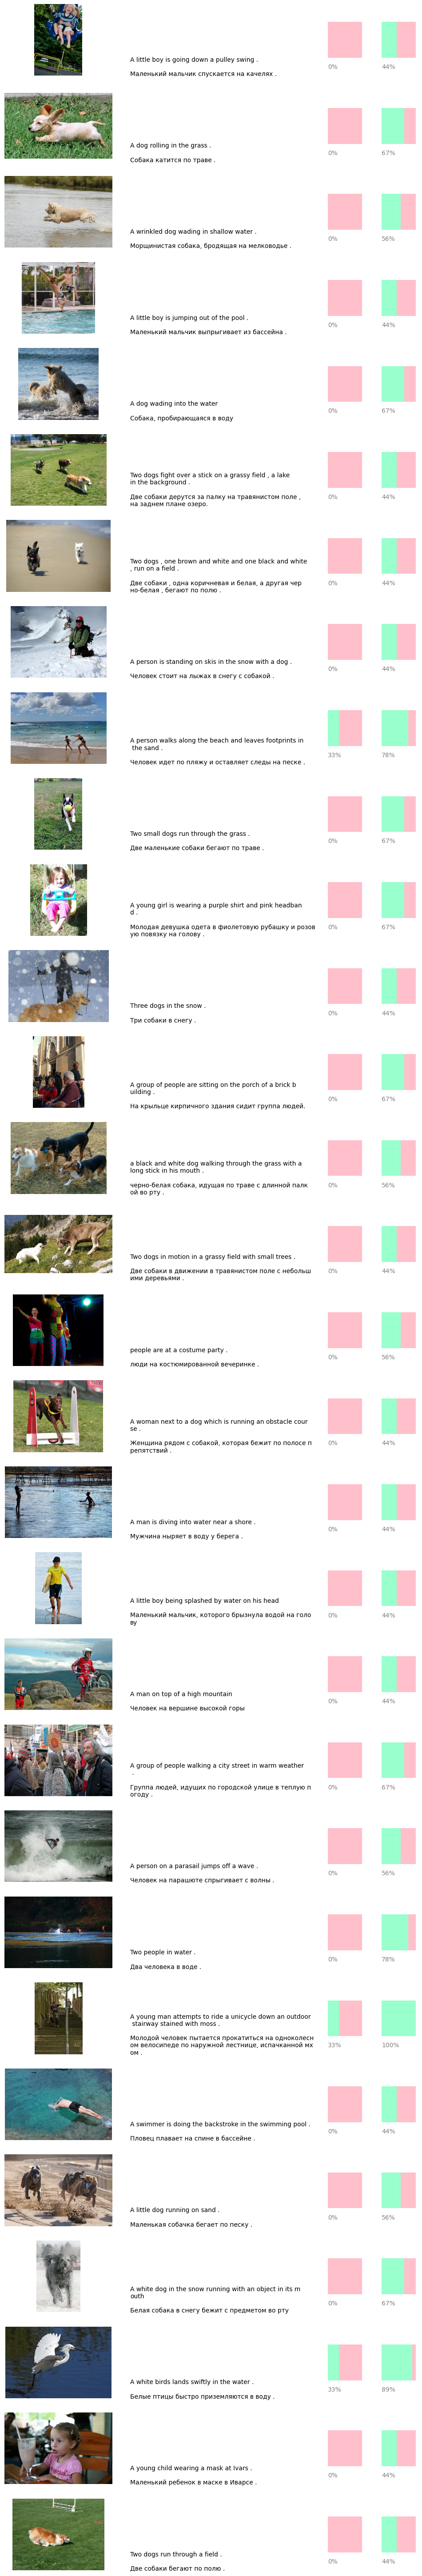

In [38]:
cprint (f"{' '*15}image{' '*30}query_text (eng/ru){' '*22}prob-ty (crowd){' '*5}prob-ty (expert)", "yellow", attrs=["bold"])
print_images_with_info(train_big_difference,30)

<a id= 'annotations'></a> Оценки экспертов более достоверны и могут быть приняты за эталонные.\
Причина разительной оценки народа и экспертов в том, что у народа было только две возможные опции (соответствует / не соответсвует), а у экспертов 4.\
Изображения с сильно различающейся оценкой - это те, которые частично удовлетворяют описанию. Эксперты в этом случае показывают вероятность соответсвия около 50%.\
Примеры ниже.\
"Two dogs run through a field." На картинке одна собака бегает по полю. Народ: 0%. Эксперты: 44%.\
"A person is standing on skis in the snow with a dog." На картинке горнолыжник мчится без собаки. Народ: 0%. Эксперты: 44%.

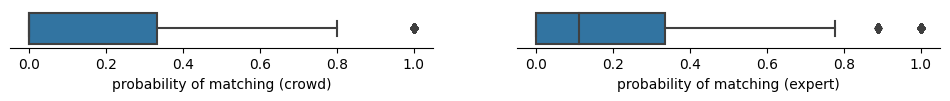

In [39]:
f, ax = plt.subplots(1,2, figsize=(12,0.5))
sns.boxplot(x=train['confirmation_share'], ax=ax[0]).set(xlabel='probability of matching (crowd)')
sns.boxplot(x=train['assessment'], ax=ax[1]).set(xlabel='probability of matching (expert)')
ax[0].set(yticks=[]); ax[1].set(yticks=[]); sns.despine(left=True)

Объединим оценки народа `confirmation_share` и экспертов `assessment` в одну `probability of matching` с весами 0.2 / 0.8 соответственно.

In [40]:
train.loc[train['confirmation_share'].isna(), 'probability_of_matching'] =\
train.loc[train['confirmation_share'].isna(), 'assessment']

train.loc[~train['confirmation_share'].isna(), 'probability_of_matching'] =\
train['confirmation_share']*0.2 + train['assessment']*0.8

In [41]:
train.drop(['confirmation_share', 'assessment'], axis=1, inplace=True) # удаление признаков, объединённых в новый

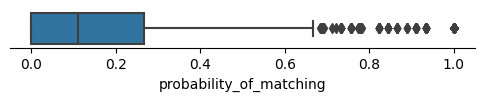

In [42]:
plt.figure(figsize=(6,0.5))
sns.boxplot(x=train['probability_of_matching']).set(yticks=[])
sns.despine(left=True)

In [43]:
# получившийся датасет train для обучения
display(train.head()); print ('Размер: ', train.shape)

image                     query_id  \
0  1056338697_4f7d7ce270.jpg  2549968784_39bfbe44f9.jpg#2   
1  1262583859_653f1469a9.jpg  2549968784_39bfbe44f9.jpg#2   
2  2447284966_d6bbdb4b6e.jpg  2549968784_39bfbe44f9.jpg#2   
3  2549968784_39bfbe44f9.jpg  2549968784_39bfbe44f9.jpg#2   
4  2621415349_ef1a7e73be.jpg  2549968784_39bfbe44f9.jpg#2   

                                          query_text  probability_of_matching  
0  A young child is wearing blue goggles and sitt...                 0.000000  
1  A young child is wearing blue goggles and sitt...                 0.000000  
2  A young child is wearing blue goggles and sitt...                 0.177778  
3  A young child is wearing blue goggles and sitt...                 1.000000  
4  A young child is wearing blue goggles and sitt...                 0.000000

Размер:  (5822, 4)


<a id= 'EDA'></a>
### Вывод по анализу данных

* Исходные материалы:<br>
\- 3 обучающих датасета (таблицы) `train_dataset` (5822 х 3), `CrowdAnnotations` (47830 х 5), `ExpertAnnotations` (5822 х 5);<br>
\- 2 датасета (таблицы) для тестирования `test_images` (100 х 1), `test_queries (500 х 3)`;\
\- изображения для обучения в директории  `train_images` (1000 шт.);\
\- изображения для тестирования в директории `test_images` (100 шт.).
* Изображения в цветовом режиме RGB в формате JPEG; самые популярные размеры, пкс: 500 х 333, 500 x 375, 333 x 500, 500 x 334, 375 x 500.
* Дубликатов, пропусков, пробелов в названиях файлов нет.
* Названия файлов и их перечень в таблицах соответсвует друг другу.
* Незначительная доля полностью верных описаний в датасетах (до 3%); не очень хорошо для обучения модели.
* Есть информация о соответствии картинки описанию от двух источников - CrowdAnnotations (большинство) и ExpertAnnotations.\
В обучающем датасете экспертная оценка есть у всех объектов, а народная оценка у 40%.\
Объединил две оценки в одну с весами 0.8, 0.2, так как экспертная оценка более достоверная из-за вариативности ответов; у народа было только 2 варианта - соответсвует/не соответствует. Подробно [выше](#annotations).
* Подготовлен обучающий датасет `train` (5822 x 4). Оценки объеденины в одну `probability_of_matching` в диапазоне значений [0,1].



## Подготовка данных к обучению модели

### Исключение запрещённого контента

В соответсвии с законодательством необходимо удалить из обучающей выборки фотографии детей.\
В обучающей выборке возьмём изображения со своим верным описанием. Проверим есть ли в описании слова, характеризующие изображение, как содержащее ребёнка.\
Данные фотографии удалим.

In [44]:
# cлова, которые могут подпадать под юридические ограничения
restricted_words = ['boy', 'girl', 'baby', 'infant', 'cub', 'kid', 'newborn', 'toddler', 'child', 'teenager', 'youngster',
                    'adolescent', 'pre-teen', 'tween', 'son', 'daughter', 'grandson', 'granddaughter', 'orphan', 'grandchild']

In [45]:
def preprocessing(x):
    '''удаляет спец. и одиночные символы, цифры, дубли, стоп-слова; лемматизация; на входе/выходе string;
       должны существовать nlp(spacy.load) и stopwords'''

    doc = re.sub(r'\W|_', ' ', x)                                     # remove all the special characters
    doc = re.sub(r'\d', ' ', doc)                                     # remove all numbers
    doc = re.sub(r'\s+[a-zA-Z]\s+([a-zA-Z]\s+)*', ' ', doc)           # remove all single characters
    doc = re.sub(r'\s+([a-zA-Z])\1+\s+(([a-zA-Z])\1+\s+)*', ' ', doc) # remove all duplicate characters
    doc = re.sub(r'^[a-zA-Z]\s+|\s+[a-zA-Z]$', ' ', doc)              # remove single characters from the start and at the end
    doc = re.sub(r'\s+', ' ', doc)                                    # substituting multiple spaces with single space
    doc = doc.lower()                                                 # converting to Lowercase
    doc = ' '.join([word for word in doc.split() if word not in stopwords]) # delete stopwords
    return ' '.join([token.lemma_ for token in nlp(doc)])             # lemmatization

# создание структуры данных для лемматизации
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])
# множество стоп-слов для удаления таковых из текста
stopwords = nlp.Defaults.stop_words|{'br', 'mr', 'mrs', 'miss', 'ms', 'bozxphd', 'â', 'ª', 'ªâ', 'âª'}

In [46]:
%%time
# создаём столбец с предобработанным описанием (удаление спец-символов, стоп-слов; лемматизация)
train['query_text_processed'] = train['query_text'].apply(lambda x: preprocessing(x))

CPU times: total: 11 s
Wall time: 11 s


In [47]:
# предобработка ограниченных слов (удаление спец-символов, стоп-слов; лемматизация)
restricted_words_processed = preprocessing(' '.join(restricted_words)).split()

In [48]:
def check_for_a_word(text):
    '''проверяет наличие ограниченных слов в text'''
    for word in text.split():
        if word in restricted_words_processed:
            return True
    return False

# объект подлежит удалению, если в описании есть запрещённое слово и вероятность соответсвия описания картинке выше 0.5
indexes_to_delete = train[(train['query_text_processed'].apply(lambda x: check_for_a_word(x))) &\
                          (train['probability_of_matching']>0.5)].index.tolist()

len(indexes_to_delete) # количество позиций, попадающих под критерии удаления

115

In [49]:
def print_images(images_df, n_images, title=None, directory = 'train_images'):
    '''выводит случайные картинки из images_df в кол-ве n_images'''
    fig = plt.figure(figsize=(12,n_images/4.5))
    plt.title(title); plt.axis('off')
    random_images = images_df['image'].sample(n_images)
    for i,random_image in enumerate(random_images):
        fig.add_subplot(ceil(n_images/7), 7, i+1)
        plt.imshow(Image.open(path + directory + '/' +random_image))
        plt.axis('off'); plt.tight_layout()

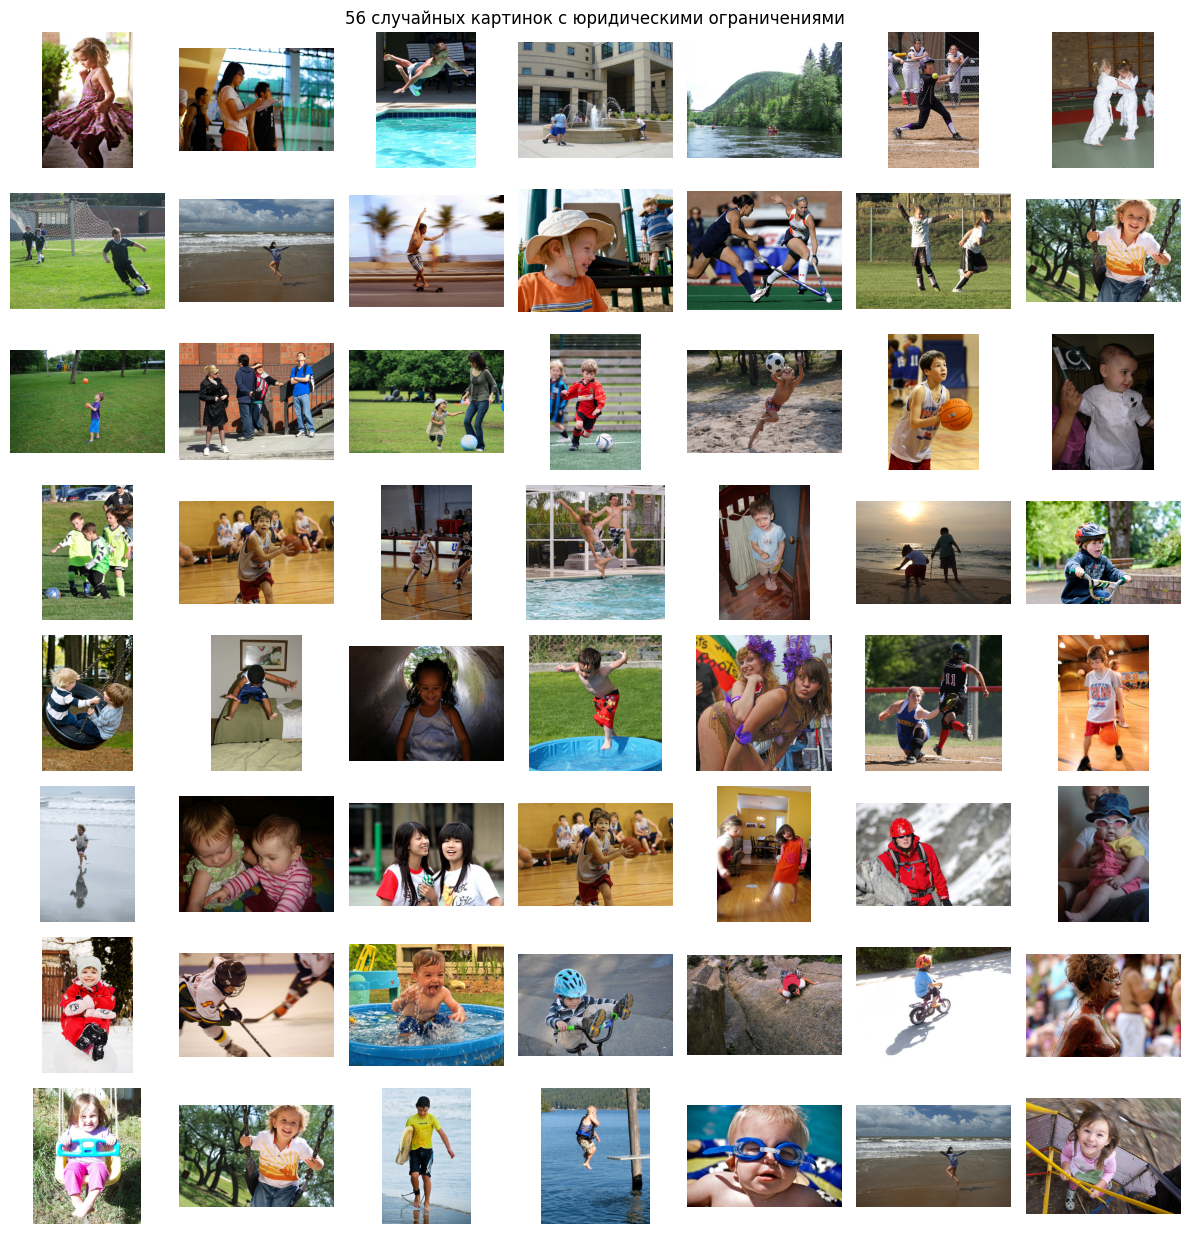

In [50]:
print_images(train.loc[indexes_to_delete], 56, '56 случайных картинок с юридическими ограничениями')

In [51]:
train.drop(indexes_to_delete, inplace=True) # удаляем запрещённый контент из обучающего датасета

In [52]:
print('размер: ', train.shape)

размер:  (5707, 5)


### Векторизация текстового описания

In [53]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [54]:
%%time
# Загрузка предобученной модели/токенизатора
tokenizer  = transformers.BertTokenizer.from_pretrained('bert-base-uncased')
model_bert = transformers.BertModel.from_pretrained('bert-base-uncased').to(device)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


CPU times: total: 3.58 s
Wall time: 10.3 s


In [55]:
def get_bert_embeddings(query_series):
    '''на основе запросов возвращает их эмбеддинги'''

    # токенизация; каждое слово трансформируется в число; в начале/ в конце добавляются 101/102
    tokenized = query_series.apply(lambda x: tokenizer.encode(x, add_special_tokens=True, truncation=True))
    # максимальная длина в каждом объекте
    max_len = tokenized.apply(lambda x: len(x)).max()
    # паддирование - дополнение нулями объектов до длины максимального объекта
    padded = np.array([i + [0]*(max_len - len(i)) for i in tokenized.values])
    # обращаем внимание модели на основные токены (добавленные нули - неважны)
    attention_mask = np.where(padded != 0, 1, 0)

    batch_size = 100
    embeddings = []

    for i in range(ceil(padded.shape[0] / batch_size)):

        # преобразуем данные в формат тензоров
        # если GPU доступен, создаём тензоры для работы на GPU; иначе - обычные тензоры для CPU
        if torch.cuda.is_available():
            batch                = torch.cuda.LongTensor(padded[batch_size*i:batch_size*(i+1)])
            attention_mask_batch = torch.cuda.LongTensor(attention_mask[batch_size*i:batch_size*(i+1)])
        else:
            batch                = torch.LongTensor(padded[batch_size*i:batch_size*(i+1)])
            attention_mask_batch = torch.LongTensor(attention_mask[batch_size*i:batch_size*(i+1)])

        # Чтобы получить эмбеддинги для батча, передадим модели данные и маску; градиенты не вычисляем
        with torch.no_grad():
            batch_embeddings = model_bert(batch, attention_mask=attention_mask_batch)

        # Из полученного тензора извлечём нужные элементы и добавим в список всех эмбеддингов.
        embeddings.append(batch_embeddings[0][:,0,:].cpu().numpy())

    # Соберём все эмбеддинги в матрицу признаков
    return np.concatenate(embeddings)

In [56]:
text_embeddings = get_bert_embeddings(train['query_text_processed'])  # рассчитываем BERT-эмбеддинги для текста

In [57]:
text_embeddings.shape

(5707, 768)

### Векторизация изображений

In [58]:
resnet = models.resnet50(pretrained=True).to(device)       #загружаем претренированную модель

In [59]:
# обучение модели для создания эмбеддингов не потребуется; заморозим веса
for param in resnet.parameters():
    param.requires_grad_(False)

In [60]:
resnet.eval()                                              # переводим модель в режим предсказания

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [61]:
def get_resnet_embeddings(file_names, directory = 'train_images'):
    '''выдаёт массив эмбеддингов для изображений, полученных с помощью модели resnet; на входе Series из file_names'''

    batch_size = 100
    embeddings = []

    # перевод изображения в нужный для модели формат
    norm = transforms.Normalize(
        mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    preprocess = transforms.Compose([
        transforms.ToTensor(),
        transforms.Resize(256),
        transforms.CenterCrop(224),
        norm])

    for i in notebook.tqdm(range(ceil(file_names.shape[0] / batch_size))):

        # загружаем данные и преобразуем в формат тензоров

        batch = file_names[batch_size*i:batch_size*(i+1)]            # батч-Series из имён файлов
        # Series из тензоров предобработанных картинок и переданных в GPU
        batch = batch.apply(lambda x: preprocess(Image.open(path + directory +'/'+ x)).to(device))
        if torch.cuda.is_available():
            batch = batch.apply(lambda x: torch.cuda.FloatTensor(x)) # перевод тензеров в формат GPU-тензеров
        batch = batch.apply(lambda x: x.reshape(1,3,224,224))  # + ещё одну размерность, т.к. ResNet принимает 4-х мер. тензоры
        batch = torch.cat(tuple(batch))                              # переводим Series в tuple и конкатенируем

        # получаем эмбеддинги; градиенты не вычисляем
        with torch.no_grad():
            batch_embeddings = resnet(batch)

        # полученный батч эмбеддингов добавим в список всех эмбеддингов
        embeddings.append(batch_embeddings.cpu().numpy())

    # Соберём все эмбеддинги в матрицу признаков
    return np.concatenate(embeddings)

In [62]:
resnet_embeddings = get_resnet_embeddings(train['image']) # рассчитываем эмбеддинги для изображений

  0%|          | 0/58 [00:00<?, ?it/s]

In [63]:
resnet_embeddings.shape

(5707, 1000)

In [64]:
X = np.concatenate([resnet_embeddings, text_embeddings],1) # объединение эмбеддингов изображения и текста
X.shape

(5707, 1768)

In [65]:
y = train['probability_of_matching'].to_numpy()
y.shape

(5707,)

Получен массив для обучения модели:
- первая часть эмбеддинга (1000 элементов) - характеристика изображения;
- вторая часть эмбеддинга (768 элементов) - характеристика текста.

Первая и вторая части примерно одной размерности (1000), что должно хорошо отразиться на обучении.
При тестировании на новых данных эти количества должны быть идентичны.

## Machine learning

Разбиение датасета на обучающую и тестовую выборки с учётом исключения попадания одного изображения сразу в несколько групп.

In [66]:
gss = GroupShuffleSplit(n_splits=1, train_size=.7, random_state=constant)
train_indices, test_indices = next(gss.split(X, y, groups=train['image'].values))
X_train, y_train = X[train_indices], y[train_indices]
X_test,  y_test  = X[test_indices],  y[test_indices]

print(X_train.shape, y_train.shape)
print(X_test.shape,  y_test.shape)
print(f'train_size_fact = {X_train.shape[0]/X.shape[0]:.4f}')

(3976, 1768) (3976,)
(1731, 1768) (1731,)
train_size_fact = 0.6967


### LinearRegression

В качестве функционала ошибки и метрики качества будем использовать Mean Absolute Error (MAE).\
Это метрика для задачи регрессии (как у нас) и наиболее комфортная для визуального интуитивного восприятия.\
MSE используется, когда мы хотим чтобы нетипичные значения целевой метрики больше влияли на модель; чтобы модель больше подстроилась под нетипичные значения.\
В нашей задаче нетипичными (более редкими значениями) являются высокие вероятности, близкие к 1.
Модель немного увеличит значение предсказания вероятности.\
Скорее всего изменения будут мало заметны.

In [67]:
%%time
model = LinearRegression()
model.fit(X_train, y_train)
mean_absolute_error(y_test, model.predict(X_test))

CPU times: total: 4.16 s
Wall time: 1.51 s


0.3383394056679892

### Ridge

In [68]:
%%time
result = []
for solver in ('svd', 'lsqr', 'sparse_cg'):
    for alpha in np.arange(0.2,1.1,0.2):

        model = Ridge(solver=solver, alpha=alpha)
        model.fit(X_train, y_train)
        result.append([solver, alpha, mean_absolute_error(y_test, model.predict(X_test))])

for alpha in np.arange(0.2,1.1,0.2):
    solver='lbfgs'

    model = Ridge(solver=solver, alpha=alpha, positive=True)
    model.fit(X_train, y_train)
    result.append([solver, alpha, mean_absolute_error(y_test, model.predict(X_test))])

result = pd.DataFrame(result, columns=['solver', 'alpha', 'mae'])

CPU times: total: 8min 42s
Wall time: 2min 54s


In [69]:
result.sort_values('mae').reset_index(drop=True)

solver  alpha       mae
0       lbfgs    0.4  0.209256
1       lbfgs    0.6  0.211186
2       lbfgs    0.2  0.212112
3       lbfgs    0.8  0.212254
4       lbfgs    1.0  0.212836
5        lsqr    1.0  0.234932
6        lsqr    0.8  0.238856
7         svd    1.0  0.240481
8   sparse_cg    1.0  0.240520
9        lsqr    0.6  0.242677
10        svd    0.8  0.245585
11  sparse_cg    0.8  0.245629
12       lsqr    0.4  0.247464
13        svd    0.6  0.252319
14  sparse_cg    0.6  0.252416
15       lsqr    0.2  0.252669
16        svd    0.4  0.261695
17  sparse_cg    0.4  0.261791
18        svd    0.2  0.276998
19  sparse_cg    0.2  0.277155

Лучшая модель линейной регресси Ridge дала результат MAE = 0.2093 при solver='lbfgs', positive=True, alpha=0.4.

### Neural network

#### Variant 1

In [70]:
class NeuralNet(nn.Module):
    def __init__ (self, n_in_neurons, n_hidden_neurons_1, n_out_neurons):
        super(NeuralNet,self).__init__()

        self.fc1 = nn.Linear(n_in_neurons, n_hidden_neurons_1)
        self.act1 = nn.ReLU()
        self.fc2 = nn.Linear(n_hidden_neurons_1, n_out_neurons)
        self.act2 = nn.Sigmoid()

    def forward(self, x):
        x = self.fc1(x)
        x = self.act1(x)
        x = self.fc2(x)
        x = self.act2(x)

        return x

In [71]:
model_1 = NeuralNet(1768,1024,1).to(device)
loss = nn.L1Loss()
optimizer = torch.optim.Adam(model_1.parameters(), lr=0.01)

In [72]:
batch_size = 100
num_epochs = 10
num_batches = ceil(len(X_train)/batch_size)

In [73]:
def neural_net(model, l2_lambda=0, print_info = True):
    '''вычисляет минимальный MAE в двойном цикле по эпохам и батчам; сообщает на какой эпохе достигнут лучший MAE_test;
       выводит динамику изменения MAE на графике;
       возможна регуляризация весов чере l2_lambda'''

    torch.manual_seed(constant)

    # если GPU доступен, создаём тензоры для работы на GPU; иначе - обычные тензоры для CPU
    if torch.cuda.is_available():
        X_train_ = torch.cuda.FloatTensor(X_train)
        X_test_  = torch.cuda.FloatTensor(X_test)
        y_train_ = torch.cuda.FloatTensor(y_train)
        y_test_  = torch.cuda.FloatTensor(y_test)
    else:
        X_train_ = torch.Tensor(X_train)
        X_test_  = torch.Tensor(X_test)
        y_train_ = torch.Tensor(y_train)
        y_test_  = torch.Tensor(y_test)

    global prediction_test_best, df_mae
    count_higher_mae = 0
    df_mae = pd.DataFrame(columns=['train', 'test'])
    for epoch in range(num_epochs):

        # случайная перестановка объектов
        order = np.random.permutation(len(X_train_))
        for batch_idx in range(num_batches):
            start_index = batch_idx*batch_size

            # получение индексов текущего батча
            batch_indexes = order[start_index:start_index+batch_size]
            X_batch = X_train_[batch_indexes]
            y_batch = y_train_[batch_indexes]

            optimizer.zero_grad()
            prediction = model.forward(X_train_)
            loss_value = loss(prediction.flatten(), y_train_)
            loss_value = loss_value + l2_lambda*sum(p.pow(2).sum() for p in model.parameters()) # добавленная регуляризация
            loss_value.backward()
            optimizer.step()

        # фиксирование MAE в конце каждой эпохи
        mae_train = loss_value.item()

        # расчёт MAE на тестовой выборке; блок кода для расчёта метрик в режиме инференса
        with torch.no_grad():
            model.eval()
            prediction_test = model.forward(X_test_)
            mae_test = loss(prediction_test.flatten(), y_test_).item()
            model.train()

        # фиксирование начальных MAE и предсказания на случай, если в самом начале попали в идеальное предсказание
        if epoch == 0:
            mae_test_best = mae_test
            prediction_test_best = prediction_test
            mae_test_last = mae_test             # техническое присвоение для начальной эпохи чтобы сработал if ниже

        # формирование df c MAE-train/test на каждой 1-ой эпохе или последней
        if epoch%1 == 0 or epoch+1 == num_epochs:
            df_mae = pd.concat([df_mae, pd.DataFrame([[mae_train, mae_test]], [epoch], ['train', 'test'])])

        # прерывание цикла, если в течении 3 эпох подряд mae_test увеличивается
        if mae_test >= mae_test_last and count_higher_mae < 3:
            count_higher_mae+=1
            mae_test_last = mae_test
        elif mae_test < mae_test_last:
            count_higher_mae = 0
            mae_test_best = mae_test
            mae_test_last = mae_test
            prediction_test_best = prediction_test
        else:
            print(' '*50) # закрашивает последнее значение счётчика эпох
            break

        print (f"Вычисляется эпоха {epoch+1} из {num_epochs}", end='\r') # счётчик эпох

    if print_info == True:
        # печать графика
        f, ax = plt.subplots(1,2, gridspec_kw={"width_ratios": (0.8, 0.2)}, figsize=(10,3))
        df_mae.plot(grid=True, title='MAE на обучающей и тестовой выборках', xlabel='эпоха', ax=ax[0])
        plt.text(0, 0.75, f"Наименьшее (на последних эпохах) \nMAE_test  = {mae_test_best:.4f}\
            достигнуто на {epoch-3}-ой эпохе.\nMAE_train = {mae_train:.4f}")
        plt.text(0, 0.5,  f"Наименьшее (на всех эпохах) \nMAE_test  = {df_mae['test'].min():.4f}\
            достигнуто на {df_mae['test'].idxmin()}-ой эпохе.\nMAE_train = {mae_train:.4f}")
        plt.text(0, 0, f"num_epochs_max = {num_epochs}, \nbatch_size = {batch_size},\
            \nlr = {optimizer.state_dict()['param_groups'][0]['lr']}, \nl2_lambda = {l2_lambda}", color='grey')
        plt.axis('off'); plt.show()

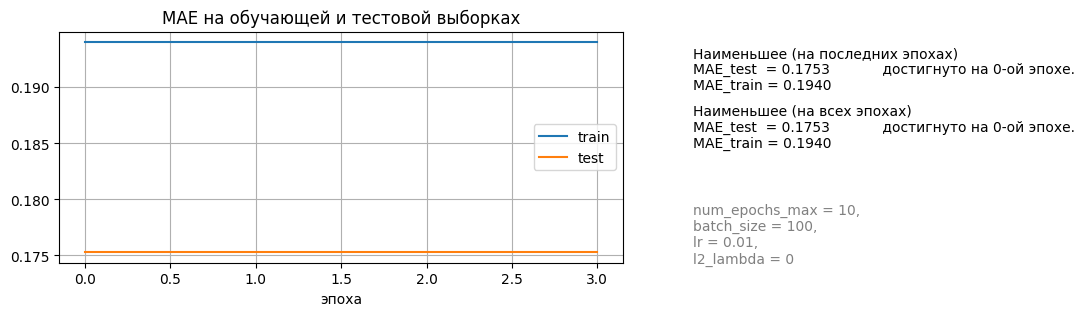

In [74]:
neural_net(model_1)

Протестирован первый базисный вариант. Linear 1768 ReLU Linear 1000 Sigmoid 1.\
batch_size = 100
num_epochs = 10
lr = 0.01

Также пробовал ф-ию потерь MSE, lr = 0.1, 0.001, batch_size 30, 50 - результат не меняется. Стабильно MAE_test = 0.1753, MAE_train = 0.1940.

При lr = 0.001 расчёт шёл дольше и незначительные колебания метрики были; в пределах 0.0001.

#### Variant 2

Убрал в конце сигмоиду.\
49 эпоха  0.130787 / 0.201562

#### Variant 3

В конец добавил ReLU - результат, как в базисе (0.1753).

#### Variant 4

В конец добавил Tanh - значительное ухудшение; стабильно - 0.8247.

#### Variant 4

Первая активации - Tanh, в конце ReLU: 0.1782.

#### Variant 5

Первая активации - LeakyReLU/Hardswish/ELU: 0.1753 (во всех случаях), как в базисе.

#### Variant 6

Добавил нормализацию после первого линейного слоя.

In [75]:
class NeuralNet(nn.Module):
    def __init__ (self, n_in_neurons, n_hidden_neurons_1, n_out_neurons):
        super(NeuralNet,self).__init__()

        self.fc1  = nn.Linear(n_in_neurons, n_hidden_neurons_1)
        self.bn1  = nn.BatchNorm1d(n_hidden_neurons_1)
        self.act1 = nn.ReLU()
        self.fc2  = nn.Linear(n_hidden_neurons_1, n_out_neurons)
        self.act2 = nn.Sigmoid()


    def forward(self, x):
        x = self.fc1(x)
        x = self.bn1(x)
        x = self.act1(x)
        x = self.fc2(x)
        x = self.act2(x)

        return x

In [76]:
model_6 = NeuralNet(1768,1024,1).to(device)
loss = nn.L1Loss()
optimizer = torch.optim.Adam(model_6.parameters(), lr=0.01)

In [77]:
batch_size = 100
num_epochs = 30
num_batches = ceil(len(X_train)/batch_size)

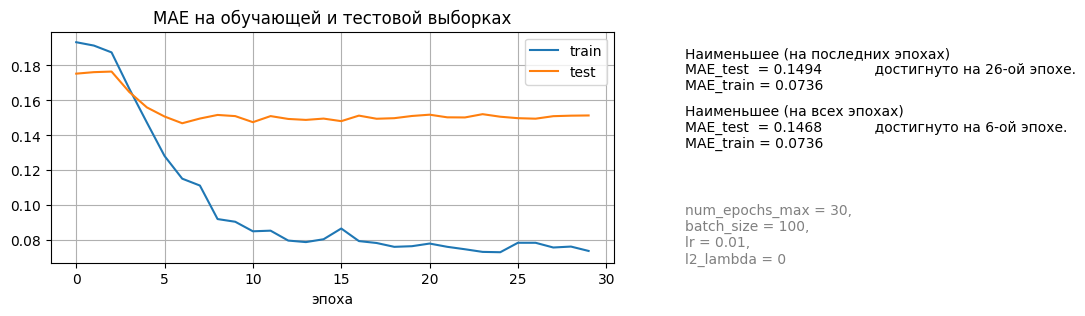

In [78]:
neural_net(model_6)

#### Variant 7

Уменьшил lr=0.001 на 50 эпохах. MAE колеблется 13.5-13.8.  Можно пробовать увеличить число эпох.

#### Variant 8

In [79]:
model_8 = NeuralNet(1768,1024,1).to(device)
loss = nn.L1Loss()
optimizer = torch.optim.Adam(model_8.parameters(), lr=0.0001)

In [80]:
batch_size = 100
num_epochs = 30
num_batches = ceil(len(X_train)/batch_size)

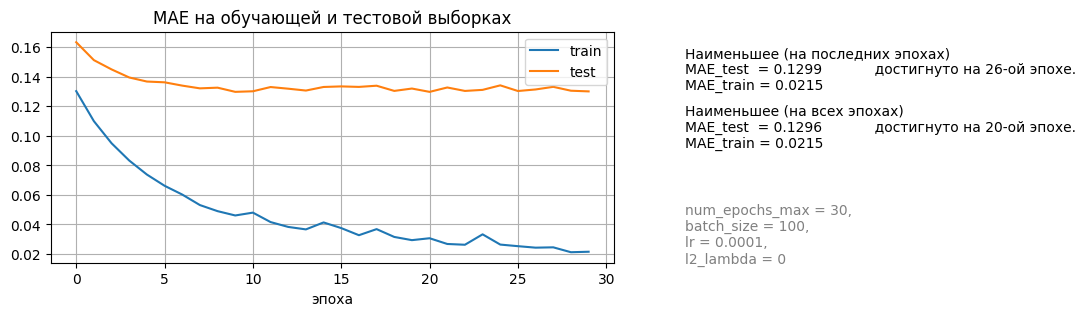

In [81]:
neural_net(model_8)

Уменьшил lr=0.0001. MAE=0.1296 на 20-ой эпохе.

#### Variant 9

Уменьшил lr=0.00001 на 100 эпохах. MAE=0.1322, пульсирует. Вариант с lr=0.0001 лучше.

#### Variant 10

Добавил ещё 1 полносвязный слой с BatchNorn и ReLU (1768,1024,323, 1).\
На 50-ой эпохе метрика колеблется 0.132-0.134.

#### Variant 10

Тоже самое, только без второго BatchNorn.\
На 50-ой эпохе метрика колеблется 0.135-0.137.

#### Variant 11

In [82]:
class NeuralNet(nn.Module):
    def __init__ (self, n_in_neurons, n_hidden_neurons_1, n_hidden_neurons_2, n_out_neurons):
        super(NeuralNet,self).__init__()

        self.fc1  = nn.Linear(n_in_neurons, n_hidden_neurons_1)
        self.bn1  = nn.BatchNorm1d(n_hidden_neurons_1)
        self.act1 = nn.ReLU()

        self.fc2  = nn.Linear(n_hidden_neurons_1, n_hidden_neurons_2)
        self.act2 = nn.ReLU()

        self.fc3  = nn.Linear(n_hidden_neurons_2, n_out_neurons)
        self.act3 = nn.Sigmoid()

    def forward(self, x):
        x = self.fc1(x)
        x = self.bn1(x)
        x = self.act1(x)
        x = self.fc2(x)
        x = self.act2(x)
        x = self.fc3(x)
        x = self.act3(x)

        return x

In [83]:
model_11 = NeuralNet(1768, 1024, 32, 1).to(device)
loss = nn.L1Loss()
optimizer = torch.optim.Adam(model_11.parameters(), lr=0.0001)

In [84]:
batch_size = 100
num_epochs = 11
num_batches = ceil(len(X_train)/batch_size)

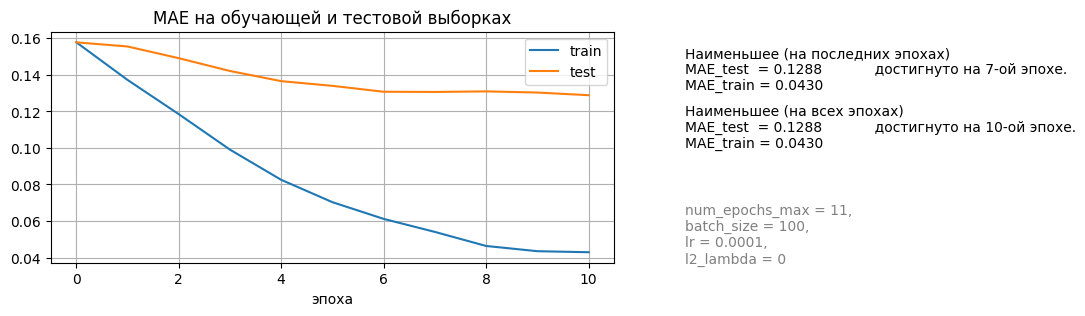

In [85]:
neural_net(model_11)

(1768,1024,32,1), только с первым BatchNorm.\
На 10-ой эпохе метрика 0.1288.\
Далее колеблется, ухудшается (экспериментировал с бОльшим числом эпох, но в итоге обучил модель на оптимальном числе эпох чтобы в дальнейшем её использовать с тестовой выборкой).

#### Variant 12

(1768,1024,32), без второго BatchNorn. После второго слоя Tanh.\
MAE_test = 0.1320 на 14-ой эпохе.

#### Variant 13

(1768,1024,512,32, 1), только с 1-ым BatchNorn, активация ReLU, в конце Sigmoid. \
На 7-ой эпохе пульсация около 0.138. Дальше ухудшается.

#### Variant 14

In [86]:
class NeuralNet(nn.Module):
    def __init__ (self, n_in_neurons, n_hidden_neurons_1, n_hidden_neurons_2, n_hidden_neurons_3, n_out_neurons):
        super(NeuralNet,self).__init__()

        self.fc1  = nn.Linear(n_in_neurons, n_hidden_neurons_1)
        self.bn1  = nn.BatchNorm1d(n_hidden_neurons_1)
        self.act1 = nn.ReLU()

        self.fc2  = nn.Linear(n_hidden_neurons_1, n_hidden_neurons_2)
        self.bn2  = nn.BatchNorm1d(n_hidden_neurons_2)
        self.act2 = nn.ReLU()

        self.fc3  = nn.Linear(n_hidden_neurons_2, n_hidden_neurons_3)
        self.bn3  = nn.BatchNorm1d(n_hidden_neurons_3)
        self.act3 = nn.ReLU()

        self.fc4  = nn.Linear(n_hidden_neurons_3, n_out_neurons)
        self.act4 = nn.Sigmoid()

    def forward(self, x):
        x = self.fc1(x)
        x = self.bn1(x)
        x = self.act1(x)
        x = self.fc2(x)
        x = self.bn2(x)
        x = self.act2(x)
        x = self.fc3(x)
        x = self.bn3(x)
        x = self.act3(x)
        x = self.fc4(x)
        x = self.act4(x)

        return x

In [87]:
model_14 = NeuralNet(1768,1024,512,32, 1).to(device)
loss = nn.L1Loss()
optimizer = torch.optim.Adam(model_14.parameters(), lr=0.0001)

In [88]:
batch_size = 100
num_epochs = 25
num_batches = ceil(len(X_train)/batch_size)

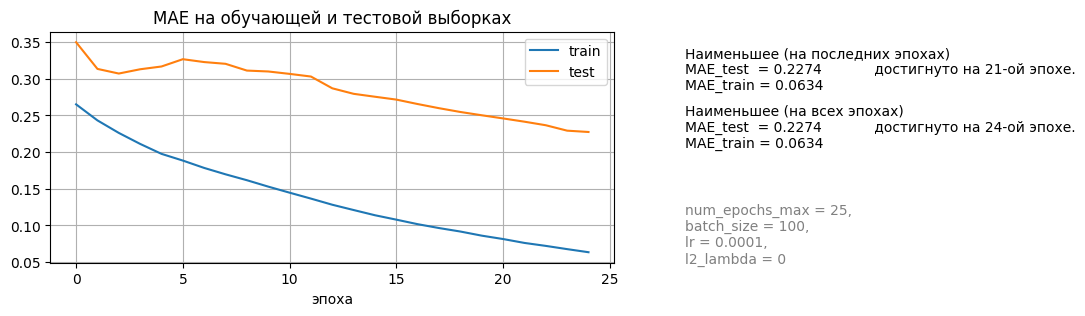

In [89]:
neural_net(model_14)

(1768,1024,512,32, 1), после первых трёх слоёв BatchNorn, активация ReLU, в конце Sigmoid. \
На 24-ой эпохе MAE = 0.23. Улучшение незначительное.

<a id= 'ML'></a>
### Вывод по ML

Построен ряд моделей, подобраны гиперпараметры.
* **LinearRegression**; MAE = <font color='red'>0.3383</font>.
* **Ridge**; перебраны гиперпараметры solver ('svd', 'lsqr', 'sparse_cg', 'lbfgs') и alpha (0.2,1.1,0.2).\
Лучшая модель линейной регресси Ridge, MAE = <font color='red'>0.2093</font> при solver='lbfgs', positive=True, alpha=0.4.
* **Neural network**; протестировано несколько архитектур с полносвязными слоями; пробовались сети с 1, 2, 3 скрытыми слоями; с/без батч-нормализации и с разными функциями активации.\
Лучший результат у model_11 с архитектурой:
\- (1768, 1024, 32, 1), после 1-ого слоя батч-нормализация, у всех слоёв кроме последнего ф-ия активации ReLU, на выходе Sigmoid; lr = 0.0001, batch_size = 100.\
MAE = <font color='red'>0.1288</font> на 10-ой эпохе.

## Тестирование модели

Изучим качество выбранной модели на тестовых данных.

In [90]:
# проверка, что индексы на тестовых датасетах монотонно увеличиваются
# необходимо для корректного дальнейшего сапоставления номеров строк np.array с индексами
# то что длина датасетов соответсвует максимальному индексу знаем из более ранних исследований
print(test_queries.index.is_monotonic_increasing)
print(test_images.index.is_monotonic_increasing)

True
True


In [91]:
model_11.eval() # переводим выбранную модель в режим предсказания

NeuralNet(
  (fc1): Linear(in_features=1768, out_features=1024, bias=True)
  (bn1): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (act1): ReLU()
  (fc2): Linear(in_features=1024, out_features=32, bias=True)
  (act2): ReLU()
  (fc3): Linear(in_features=32, out_features=1, bias=True)
  (act3): Sigmoid()
)

In [92]:
# рассчитываем эмбеддинги изображений
resnet_embeddings_test = get_resnet_embeddings(test_images['image'], directory = 'test_images')
resnet_embeddings_test.shape

  0%|          | 0/1 [00:00<?, ?it/s]

(100, 1000)

In [93]:
def predict_image(query):
    '''по входящей строке запроса подбирает фотографию из тестового пула (100 шт.)'''

    text = preprocessing(query)  # предобработка запроса (удаление спец-символов, стоп-слов; лемматизация)
    if check_for_a_word(text):
        cprint (query, 'yellow', attrs=['bold'])
        cprint ('This image is unavailable in your country in compliance with local laws.', 'yellow', attrs=['reverse'])
        return

    text = get_bert_embeddings(pd.Series(text))[0] # преобразование запроса в эмбеддинг

    # объединённый эмбеддинг: изображение (разные, 100 шт.) + описание (одно и то же)
    embeddings_test = np.concatenate([resnet_embeddings_test,
                                      np.full(shape=(100,768), fill_value=text)],
                                      axis=1)
    if torch.cuda.is_available():
        embeddings_test = torch.cuda.FloatTensor(embeddings_test)
    else:
        embeddings_test = torch.Tensor(embeddings_test)

    # предсказание вероятности соответсвия картинки тексту (размер: {число изображений} х 1)
    with torch.no_grad():
        probability_of_matching = model_11.forward(embeddings_test).detach().cpu().numpy()

    # изображение с максимальной вероятностью
    image_max_probability = test_images['image'][probability_of_matching.argmax()]
    df = pd.DataFrame([[image_max_probability, query, probability_of_matching.max()]],
                      columns = ['image', 'query_text', 'probability_of_matching'])

    print_one_image_with_info(df)

In [94]:
def print_one_image_with_info(images_df, directory = 'test_images'):
    '''выводит одно изображение с описанием и вероятностью соответствия картинки и описанию'''
    f, ax = plt.subplots(1,3, figsize=(14,2.5), gridspec_kw={"width_ratios": (0.4, 0.4, 0.2)})
    ax[0].imshow(Image.open(path + directory + '/' + images_df.loc[0, 'image']))
    query_text = images_df.loc[0, 'query_text']
    query_text_ru = translator.translate(query_text)
    ax[1].text(0, 0, word_wrap(query_text,50)+'\n'*2+word_wrap(query_text_ru,39))
    probability_of_matching = images_df.loc[0, 'probability_of_matching']
    pd.DataFrame([[probability_of_matching,1-probability_of_matching]]).\
                   plot(kind='barh', stacked=True, color=['#99ffcc', 'pink'], ax=ax[2], legend=False)
    ax[2].annotate(str(round(probability_of_matching*100))+'%', xy=(0,-0.4), color='grey')

    for axs in ax.ravel():
        axs.set_axis_off()

    plt.show()

Изображения, подобранные моделью по запросам из тестовой выборки:

               image                                   query_text (eng/ru)                         probability_of_matching
A woman and girl riding downhill on a sled with a dog running alongside them
This image is unavailable in your country in compliance with local laws.
The young boy flings mud at the barefoot girl in the pond .
This image is unavailable in your country in compliance with local laws.
A group of girls wearing costumes stand in a park .
This image is unavailable in your country in compliance with local laws.
A boy walks across a rope structure on a playground .
This image is unavailable in your country in compliance with local laws.


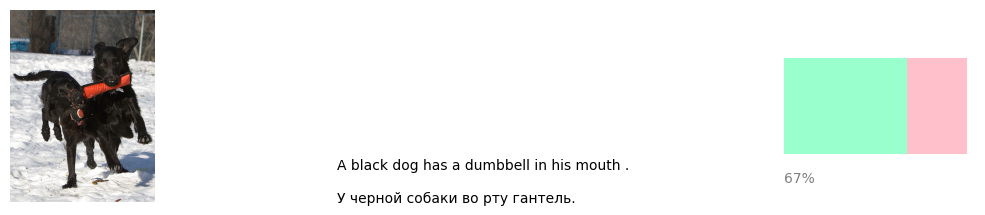

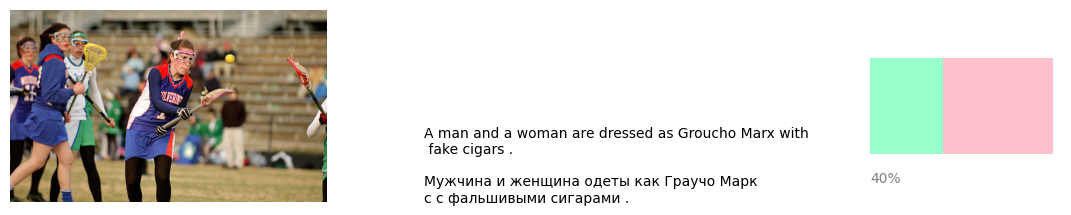

An Afican American woman standing behind two small African American children .
This image is unavailable in your country in compliance with local laws.


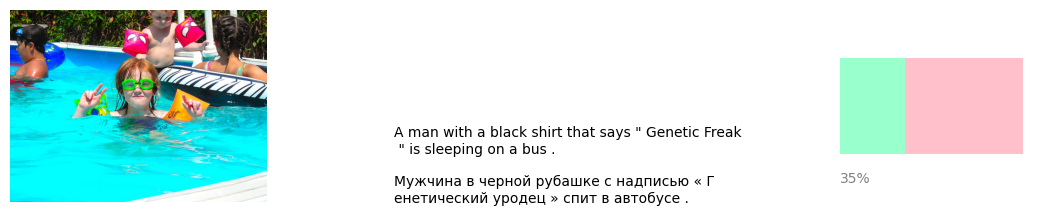

a baby is holding a controller to a video game above his head .
This image is unavailable in your country in compliance with local laws.


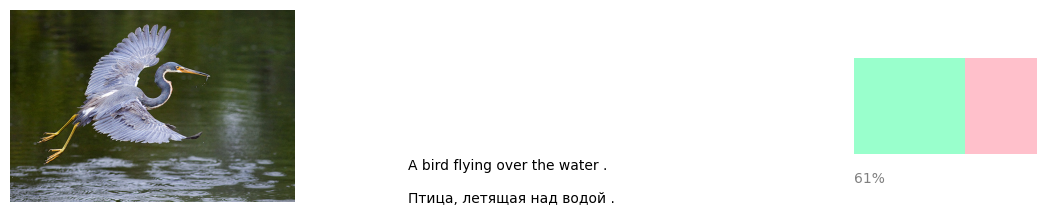

A girl in a bikini top stands in front of a beautiful view .
This image is unavailable in your country in compliance with local laws.
A girl in a cape along with other costumed children
This image is unavailable in your country in compliance with local laws.
A child in a blue shirt sitting on a forest floor , looking through binoculars .
This image is unavailable in your country in compliance with local laws.
A little boy plays with a basketball and a toy basketball hoop .
This image is unavailable in your country in compliance with local laws.
A young boy is holding a PlayStation controller over his head .
This image is unavailable in your country in compliance with local laws.


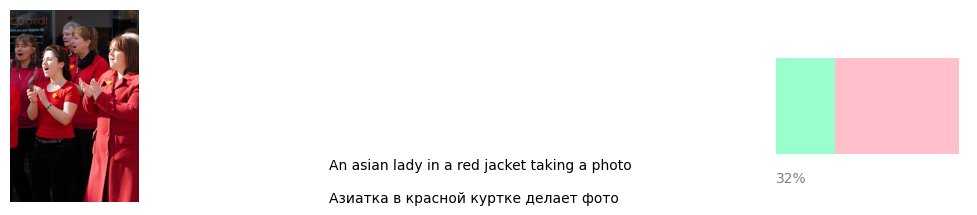

The three children are standing on and by a fence .
This image is unavailable in your country in compliance with local laws.


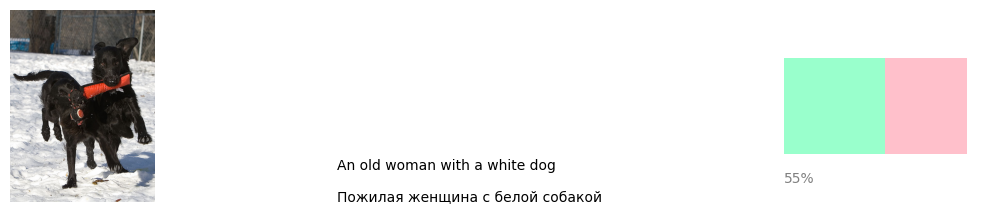

The little girl tackles a man and makes the universal sign for " Touchdown ! "
This image is unavailable in your country in compliance with local laws.
A small girl sitting on a man 's back .
This image is unavailable in your country in compliance with local laws.


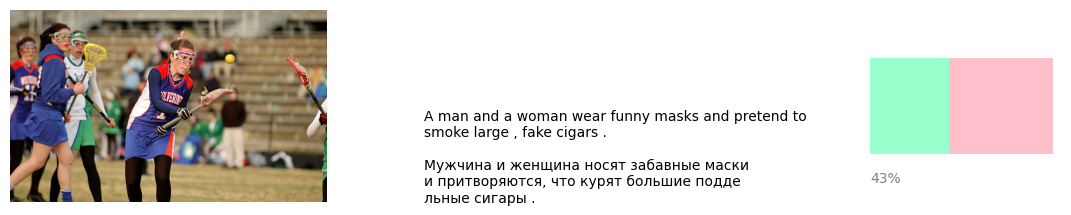

A man lies on a blue blanket with a child on his back .
This image is unavailable in your country in compliance with local laws.


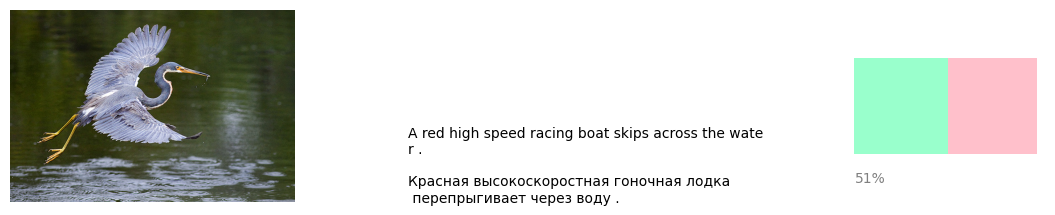

A crowd of children .
This image is unavailable in your country in compliance with local laws.


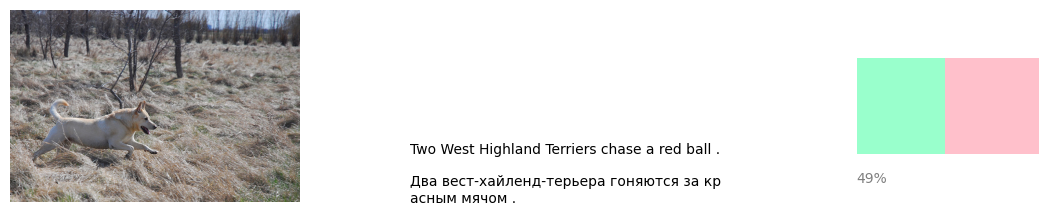

A playful puppy bites the shirt of a young boy .
This image is unavailable in your country in compliance with local laws.


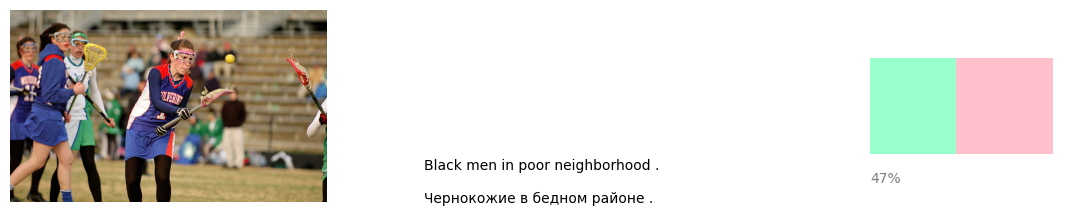

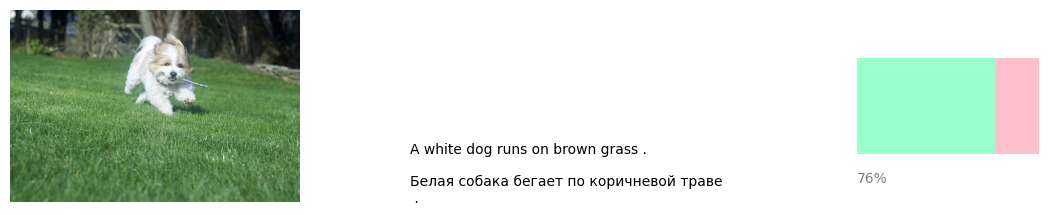

A little boy in a green soccer uniform is running on the grass .
This image is unavailable in your country in compliance with local laws.
Two children are playing at a water park .
This image is unavailable in your country in compliance with local laws.


In [95]:
cprint (f"{' '*15}image{' '*35}query_text (eng/ru){' '*25}probability_of_matching", "magenta", attrs=["bold"])
for query in test_queries['query_text'].sample(30, random_state=state):
    predict_image(query)

По моей субъективной оценке модель на тестовой выборке отработала с качеством 0.34.

| Уровень соответсвия<br>картинки запросу | 0.00 | 0.25 | 0.50 | 0.75 | 1.00 |
| --- | --- | --- | --- | --- | --- |
| Количество изображений <br>с данным уровнем соответствия| 5 | 2 | 1 | 1 | 2 |

$(0*5+0.25*2+0.5*1+0.75*1+1*2)/11=0.34$

## Вывод

Модель по подбору изображения на основе текстового описания может быть изготовлена с учётом некоторых дороботок относительно сделанного PoC (Proof of Concept).

* Необходимо улучшить качество работы модели за счёт:\
\* расширения пула картинок, на которых обучалась модель; в том числе за счёт аугментации положительных примеров;\
\* поэксперементировать с другими предобученными моделями для создания эмбеддингов;\
\* попробовать подобрать более оптимальную архитектуру нейроной сети для обучения.
* Выдавать на запрос не одно изображение, а 10. Вероятность нахождения пользователем нужной картинки значительно увеличится.

<br>

По сути проведённой работы:
* анализ исходных данных см. в [п.1.1](#EDA);
* признаки для обучения моделей подготовлены в виде эмбеддингов с помощью BERT (для текста) и ResNet50 (для изображений);\
полученная длина конкатенированных признаков 1768 (1000 изображение + 768 текст);
* построенные модели: LinearRegression, Ridge, Neural network с различными гиперпараметрами и архитектурой;\
лучший результат у полносвязной нейронной сети; MAE = 0.1288; подробнее см. в [п.3.4 Вывод по ML](#ML).
* проверка модели на тестовых данных визуально продемонстировала качество работы алгоритма около **34%** (по "мнению" модели вероятность соответсвия подобранных картинок 52%).
